In [141]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping
from tools.extract import generateNNdata
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.losses import MeanSquaredError

import torch
from torch import nn
from torch import functional as F
from lstmmodel import lstmTorch

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [142]:
def genXy(data, lb, la, scaler):
    n_features = data.shape[1] - 2
    df = data.reset_index(drop=True)

    X = np.empty((0, lb, n_features))
    y = np.empty((0, la, 2))

    X_time = np.array([], dtype="datetime64")
    y_time = np.array([], dtype="datetime64")

    for i, row in tqdm(df.iterrows()):
        dfx = df.iloc[i : i + lb]
        x_vals = dfx.drop(columns=["timeslot", "date"]).values

        dfy = df.iloc[i + lb : i + lb + la]
        y_vals = dfy[["arrivalsArrivalDelay", "departuresDepartureDelay"]].values

        if dfx.shape[0] < lb or dfy.shape[0] < la:
            continue

        # if dfx.date.nunique() > 1 or dfy.date.nunique() > 1:
        #     continue

        # if dfx.date.unique()[0] != dfy.date.unique()[0]:
        #     continue

        x_vals = scaler.transform(x_vals)
        X = np.vstack((X, x_vals[None]))
        y = np.vstack((y, y_vals[None]))

        X_time = np.append(X_time, dfx.timeslot.iloc[0])
        y_time = np.append(y_time, dfy.timeslot.iloc[0])

    return X, y, X_time, y_time

In [143]:
timeinterval = 30
airport = "EGLL"
lookback, lookahead = 6, 6

In [144]:
dataset = (
    generateNNdata(
        airport,
        timeinterval=timeinterval,
        start=datetime(2018, 1, 1),
        end=datetime(2019, 12, 31),
        catagoricalFlightDuration=False,
        forceRegenerateData=False,
    )
    .drop(columns=["departuresArrivalDelay", "arrivalsDepartureDelay"])
)

In [145]:
# randomly split train, test

# np.random.seed(42)
dates = dataset.date.sort_values().unique()
# np.random.shuffle(dates)

idx_split = int(len(dates) * 0.80)

train_dates = dates[:idx_split]
test_dates = dates[idx_split:]

train_data = dataset.query("date in @train_dates").sort_values('timeslot')
test_data = dataset.query("date in @test_dates").sort_values('timeslot')

In [146]:
scaler = StandardScaler()
scaler.fit(dataset.drop(columns=["timeslot", "date"]).values)

StandardScaler()

In [196]:
X_train, y_train, X_train_time, y_train_time = genXy(train_data, lookback, lookahead, scaler)
X_test, y_test, X_test_time, y_test_time = genXy(test_data, lookback, lookahead, scaler)

y_train_arr, y_train_dep = y_train[:, :, 0], y_train[:, :, 1]
y_test_arr, y_test_dep = y_test[:, :, 0], y_test[:, :, 1]

9312it [00:32, 285.11it/s]
2352it [00:05, 459.44it/s]


In [148]:
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]

In [149]:
inputs = layers.Input((lookback, n_features))
lstm1 = layers.LSTM(200, return_sequences=True)
lstm2 = layers.LSTM(200, return_sequences=False)
dense1 = layers.Dense(200)
dropout1 = layers.Dropout(0.25)
dense2 = layers.Dense(100)
output = layers.Dense(lookahead * 2)
reshape = layers.Reshape((lookahead, 2))

out = lstm1(inputs)
out = lstm2(out)
out = dense1(out)
out = dropout1(out)
out = dense2(out)
outputs = output(out)
outputs = reshape(outputs)

model = models.Model(inputs, outputs)

optimizer = optimizers.Adam()
model.compile(
    optimizer=optimizer,
    loss=MeanSquaredError(reduction="auto", name="mean_squared_error"),
    weighted_metrics=["acc"],
)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 6, 12)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 6, 200)            170400    
                                                                 
 lstm_5 (LSTM)               (None, 200)               320800    
                                                                 
 dense_6 (Dense)             (None, 200)               40200     
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_7 (Dense)             (None, 100)               20100     
                                                                 
 dense_8 (Dense)             (None, 12)                1212

Epoch 1/100
291/291 [==============================] - 7s 14ms/step - loss: 54.3500 - acc: 0.8790 - val_loss: 48.0679 - val_acc: 0.8840
Epoch 2/100
291/291 [==============================] - 3s 12ms/step - loss: 37.6814 - acc: 0.8896 - val_loss: 55.6602 - val_acc: 0.8535
Epoch 3/100
291/291 [==============================] - 3s 12ms/step - loss: 35.6656 - acc: 0.8932 - val_loss: 55.9008 - val_acc: 0.8360
Epoch 4/100
291/291 [==============================] - 3s 12ms/step - loss: 34.7586 - acc: 0.8946 - val_loss: 55.0248 - val_acc: 0.8294
Epoch 5/100
291/291 [==============================] - 3s 11ms/step - loss: 33.0917 - acc: 0.8914 - val_loss: 52.8032 - val_acc: 0.8283
Epoch 6/100
291/291 [==============================] - 3s 11ms/step - loss: 32.3484 - acc: 0.8943 - val_loss: 53.8556 - val_acc: 0.8265
Epoch 7/100
291/291 [==============================] - 3s 12ms/step - loss: 31.5021 - acc: 0.8937 - val_loss: 51.3932 - val_acc: 0.8387
Epoch 8/100
291/291 [===========================

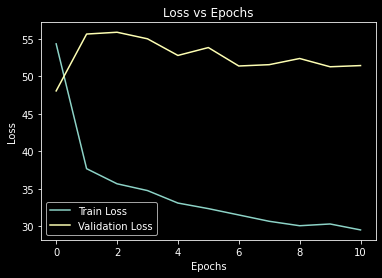

In [150]:
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=10)

# Fit data
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    # verbose=0,
    shuffle=False,
    callbacks=[es],
)

# Plot loss
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Pytorch version

In [151]:
print(torch.cuda.device_count())
gpu = cuda0 = torch.device('cuda:0')
gpuName = torch.cuda.get_device_name(0)
print(gpuName)

1
NVIDIA GeForce GTX 1060 6GB


In [152]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self, X, y, device=gpu):
        self.X = torch.tensor(X, dtype=torch.float32, device=device)
        self.y = torch.tensor(y, dtype=torch.float32, device=device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

trainset = CustomDataset(X_train, y_train)
testset = CustomDataset(X_test, y_test)

In [153]:
print(X_train.shape)
print(y_train.shape)

# X_trainT = torch.tensor(X_train, device=gpu)
# y_trainT = torch.tensor(y_train, device=gpu)

# y_trainTD = torch.utils.data.DataLoader(y_trainT, batch_size=64)

# print(type(X_trainTD))    
# print((X_trainTD.view()))
trainLoader = torch.utils.data.DataLoader(trainset , batch_size=64, drop_last=True)
testLoader = torch.utils.data.DataLoader(testset , batch_size=64, drop_last=True)

train_features, train_labels = next(iter(trainLoader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

(9301, 6, 12)
(9301, 6, 2)
Feature batch shape: torch.Size([64, 6, 12])
Labels batch shape: torch.Size([64, 6, 2])


In [220]:
class lstmTorch(nn.Module):
    def __init__(self, Nfeatures=12, lookAhead=6, dropoutAmount=0.25, LSTMSize=200, batchSize=64):
        super(lstmTorch, self).__init__()
        self.lstm = nn.LSTM(
            input_size=Nfeatures, hidden_size=200, num_layers=3, batch_first=True
        )
        self.dense1 = nn.Linear(LSTMSize, LSTMSize)

        self.dropoutAmount = dropoutAmount
        self.dropoutt = nn.Dropout(self.dropoutAmount)

        self.relu = nn.ReLU()

        self.dense2 = nn.Linear(LSTMSize, int(LSTMSize/2))
        self.dense3 = nn.Linear(int(LSTMSize/2), 12)

        self.lookAhead = lookAhead
        self.batchSize = batchSize

    def forward(self, x):
        x, _ = self.lstm(x)

        x = x[:, -1, :]
        x = self.relu(x)
        x = self.dense1(x)
        x = self.dropoutt(x)
        x = self.dense2(x)
        x = self.dense3(x)


        x = torch.reshape(x, (self.batchSize, self.lookAhead, 2))

        return x

In [223]:
# showcase model

model2 = lstmTorch().to(gpu)

criterion = nn.L1Loss()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)
print(model2)
# print(optimizer)
print(len(trainLoader))

lstmTorch(
  (lstm): LSTM(12, 200, num_layers=3, batch_first=True)
  (dense1): Linear(in_features=200, out_features=200, bias=True)
  (dropoutt): Dropout(p=0.25, inplace=False)
  (relu): ReLU()
  (dense2): Linear(in_features=200, out_features=100, bias=True)
  (dense3): Linear(in_features=100, out_features=12, bias=True)
)
145


In [224]:
history = []
epochs=150

for epoch in (range(epochs)):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainLoader, 0):
        # get the inputs
        inputs, labels = data
        # print(inputs.shape)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    history.append(loss.item())
    if epoch % 5 == 0:
        print(f"Epoch: {epoch} | loss: {running_loss/len(trainLoader)}")

print('Finished Training')

Epoch: 0 | loss: 111.07073156422582
Epoch: 5 | loss: 40.55938594423491
Epoch: 10 | loss: 35.12539995127711
Epoch: 15 | loss: 33.390231132507324
Epoch: 20 | loss: 31.611154977206525
Epoch: 25 | loss: 30.281114650594777
Epoch: 30 | loss: 29.35796311477135
Epoch: 35 | loss: 28.44380387273328
Epoch: 40 | loss: 27.664215660095216
Epoch: 45 | loss: 26.78186004244048
Epoch: 50 | loss: 26.27654173620816
Epoch: 55 | loss: 25.705524095995674
Epoch: 60 | loss: 25.134614365676352
Epoch: 65 | loss: 24.496157166053507
Epoch: 70 | loss: 25.91070392871725
Epoch: 75 | loss: 23.742854052576526
Epoch: 80 | loss: 23.037744627327754
Epoch: 85 | loss: 22.123875992873618
Epoch: 90 | loss: 21.501430274700297
Epoch: 95 | loss: 20.82488649960222
Epoch: 100 | loss: 19.906094781283674
Epoch: 105 | loss: 19.509795780839593
Epoch: 110 | loss: 19.362720305344155
Epoch: 115 | loss: 18.81742777331122
Epoch: 120 | loss: 18.263634859282394
Epoch: 125 | loss: 17.68138435626852
Epoch: 130 | loss: 17.38584377025736
Epoch: 

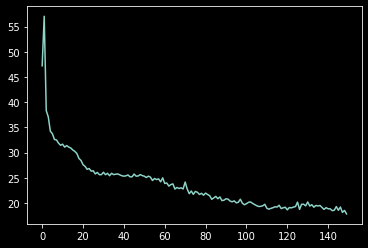

In [225]:
plt.plot(list(range(epochs)), history)

In [226]:
loss = 0
total = 0
y_pred = []
with torch.no_grad():
    for data in testLoader:
        featureset, labels = data
        outputs = model2(featureset)
        # _, predicted = torch.max(outputs.data, 1)
        lossIndiv = torch.mean(torch.abs(outputs-labels))
        y_pred.append(np.array(outputs.cpu()))
        total += labels.size(0)
        # correct += (predicted == labels).sum().item()
        loss += lossIndiv

print(f"avg MAE: {(loss / total)}")
y_pred = np.array(y_pred).reshape((64*36, 6, 2))
print(y_pred.shape)
# print(y_pred)

print(np.count_nonzero(np.isnan(y_pred))
)

avg MAE: 0.07751573622226715
(2304, 6, 2)
0


(0.0, 100.0)

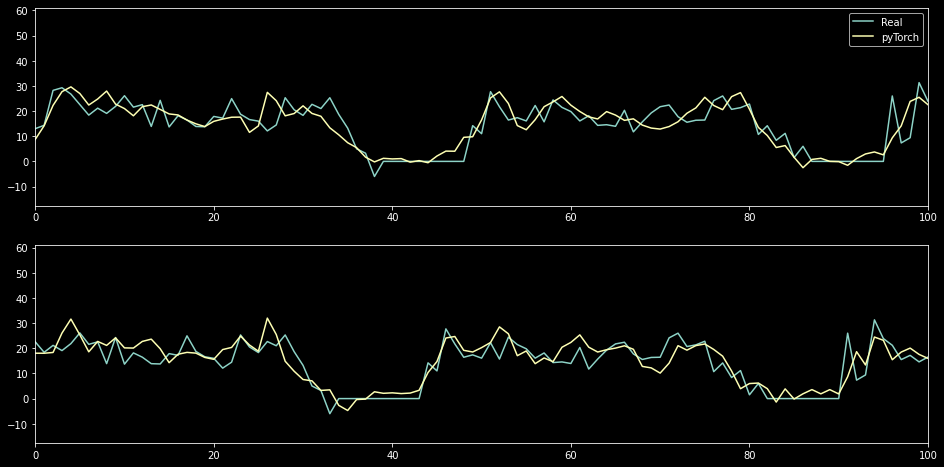

In [238]:
y_test_hat = model.predict(X_test)
y_test_hat2 = y_pred

real = y_test[:-37]
predTF = y_test_hat[:-37]
predPT = y_test_hat2


fig, ax = plt.subplots(2,1)
arrival = 0
# ax.plot(predTF[:, 5, 0], label="Keras")
ax[0].plot(real[:, 0, arrival], label="Real")
ax[0].plot(predPT[:, 0, arrival], label="pyTorch")
ax[1].plot(real[:, 5, arrival], label="Real")
ax[1].plot(predPT[:, 5, arrival], label="pyTorch")

fig.set_figwidth(16)
fig.set_figheight(8)

ax[0].legend()

ax[0].set_xlim(0, 100)
ax[1].set_xlim(0, 100)

In [212]:
results = pd.concat(
    [
        pd.DataFrame().assign(time=y_test_time),
        pd.DataFrame(
            y_test[:, :, 0].round().astype(int),
            columns=[f"arr_{n}m" for n in range(30, 181, 30)],
        ),
        pd.DataFrame(
            y_test[:, :, 1].round().astype(int),
            columns=[f"dep_{n}m" for n in range(30, 181, 30)],
        ),
        pd.DataFrame(
            y_test_hat[:, :, 0].round().astype(int),
            columns=[f"arr_est_{n}m" for n in range(30, 181, 30)],
        ),
        pd.DataFrame(
            y_test_hat[:, :, 1].round().astype(int),
            columns=[f"dep_est_{n}m" for n in range(30, 181, 30)],
        ),
    ],
    axis=1,
)

# results

In [213]:
res = dict()
for i in range(1, 7):
    res[i] = {
        "arr_mae": mean_absolute_error(results[f"arr_{i*30}m"], results[f"arr_est_{i*30}m"]),
        "arr_rmse": mean_squared_error(
            results[f"arr_{i*30}m"], results[f"arr_est_{i*30}m"], squared=False
        ),
        "arr_r2": r2_score(results[f"arr_{i*30}m"], results[f"arr_est_{i*30}m"]),
        "dep_mae": mean_absolute_error(results[f"dep_{i*30}m"], results[f"dep_est_{i*30}m"]),
        "dep_rmse": mean_squared_error(
            results[f"dep_{i*30}m"], results[f"dep_est_{i*30}m"], squared=False
        ),
        "dep_r2": r2_score(results[f"dep_{i*30}m"], results[f"dep_est_{i*30}m"]),
    }

pd.DataFrame.from_dict(res, orient="index")

,arr_mae,arr_rmse,arr_r2,dep_mae,dep_rmse,dep_r2
1,5.782144,7.333049,0.380058,1.659120,2.410996,0.400847
2,6.500641,9.026942,0.060435,1.543785,2.427945,0.392394
3,7.393849,10.787866,-0.342193,1.464759,2.413209,0.399747
4,8.474584,11.192865,-0.448320,1.495515,2.554071,0.327626
5,8.426314,10.637356,-0.311569,1.557027,2.591429,0.307813
6,7.205895,9.685596,-0.089751,1.636480,2.648495,0.276993


In [214]:
results.to_csv("data/airport_delay_lstm_results.csv", index=False)

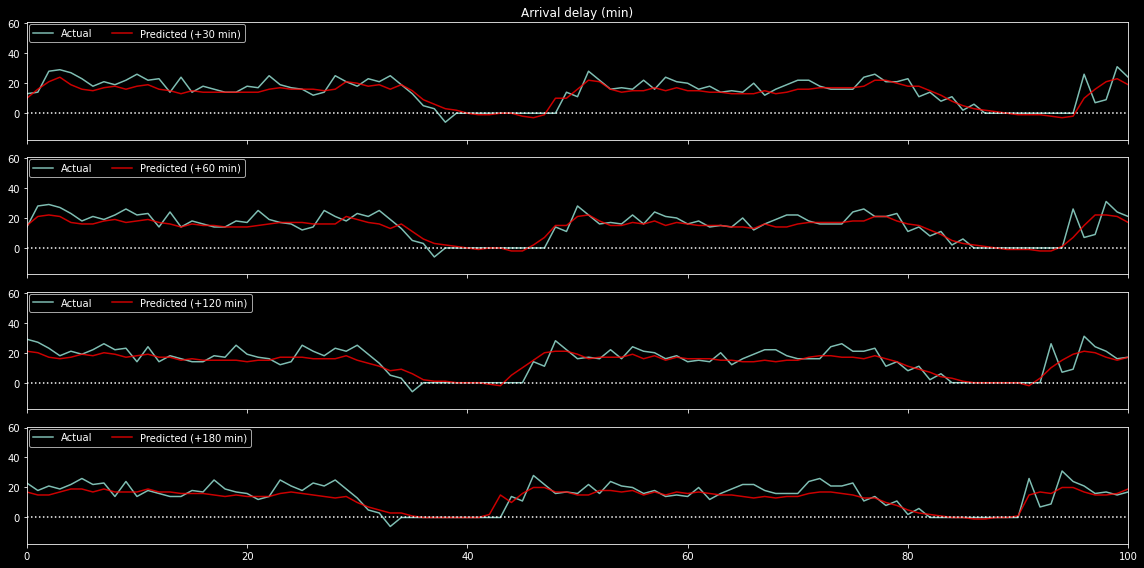

In [215]:
df = results

fig, axes = plt.subplots(4, 1, figsize=(16, 8), sharex=True, sharey=True)

ax = axes[0]
ax.plot(df.arr_30m, alpha=0.9, label="Actual")
ax.plot(df.arr_est_30m, color="r", alpha=0.8, label="Predicted (+30 min)")
ax.axhline(0, ls=":")
ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)
ax.set_title("Arrival delay (min)")


ax = axes[1]
ax.plot(df.arr_60m, alpha=0.9, label="Actual")
ax.plot(df.arr_est_60m, color="r", alpha=0.8, label="Predicted (+60 min)")
ax.axhline(0, ls=":")
ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)

ax = axes[2]
ax.plot(df.arr_120m, alpha=0.9, label="Actual")
ax.plot(df.arr_est_120m, color="r", alpha=0.8, label="Predicted (+120 min)")
ax.axhline(0, ls=":")
ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)

ax = axes[3]
ax.plot(df.arr_180m, alpha=0.9, label="Actual")
ax.plot(df.arr_est_180m, color="r", alpha=0.8, label="Predicted (+180 min)")
ax.axhline(0, ls=":")
ax.legend(loc="upper left", borderaxespad=0.2, ncol=2)

ax.set_xlim(0, 100)

plt.tight_layout()